In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)

In [2]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

***
## load models

In [3]:
files = glob("../input/ump-artifacts/lgbm-linear-dart/lgbm-seed*.txt")
display(files)

boosters_lgbm_linear_dart = [lgb.Booster(model_file=fn) for fn in files]
display(boosters_lgbm_linear_dart)

['../input/ump-artifacts/lgbm-linear-dart/lgbm-seed2.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed19.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed23.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed7.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed11.txt']

***
## model finetuning on newest data

In [4]:
feat_names = [f"f_{i}" for i in range(300)]
col_names = feat_names + ["target"]

supp_data = pd.read_csv("../input/ubiquant-market-prediction/supplemental_train.csv", usecols=col_names)
supp_data = reduce_mem_usage(supp_data, verbose=True)
gc.collect()

Mem. usage decreased to 1082.73 Mb (50.0% reduction)


30

In [5]:
train_dset = lgb.Dataset(
    data=supp_data[feat_names],
    label=supp_data["target"].values,
    free_raw_data=False,
)
del supp_data
gc.collect()

0

In [6]:
# same params used for training, except num_iteration (was lowered 1900->450) and max_drop was increased (5->20)
model_params = {
    'boosting': 'dart',
    'linear_tree': True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_bin': 511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 1.0,
    'drop_rate': 0.05,
    'feature_fraction': 0.15000000000000002,
    'lambda_l1': 3.2608153782775893,
    'lambda_l2': 24.65715474841406,
    'linear_lambda': 15.831719022196562,
    'max_drop': 20,
    'min_data_in_leaf': 2200,
    'num_iterations': 450,
    'path_smooth': 4.714076496843463,
    'skip_drop': 0.65
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1920]	training's rmse: 0.370585	training's pearsonr: 0.00248973
[1940]	training's rmse: 0.311169	training's pearsonr: 0.00421807
[1960]	training's rmse: 0.296473	training's pearsonr: 0.0077379
[1980]	training's rmse: 0.29655	training's pearsonr: 0.00978582
[2000]	training's rmse: 0.298379	training's pearsonr: 0.0115317
[2020]	training's rmse: 0.296371	training's pearsonr: 0.0137478
[2040]	training's rmse: 0.292709	training's pearsonr: 0.0166341
[2060]	training's rmse: 0.291186	training's pearsonr: 0.0203389
[2080]	training's rmse: 0.292608	training's pearsonr: 0.0217839
[2100]	training's rmse: 0.292028	training's pearsonr: 0.0239229
[2120]	training's rmse: 0.291421	training's pearsonr: 0.0268471
[2140]	training's rmse: 0.290499	training's pearsonr: 0.0302735
[2160]	training's rmse: 0.289999	training's pearsonr: 0.0337173
[2180]	training's rmse: 0.28941	training's pearsonr: 0.0384501
[2200]	training's rmse: 0.289397	training's pearsonr: 0.0415727
[2220]	training's rmse: 0.289598	traini

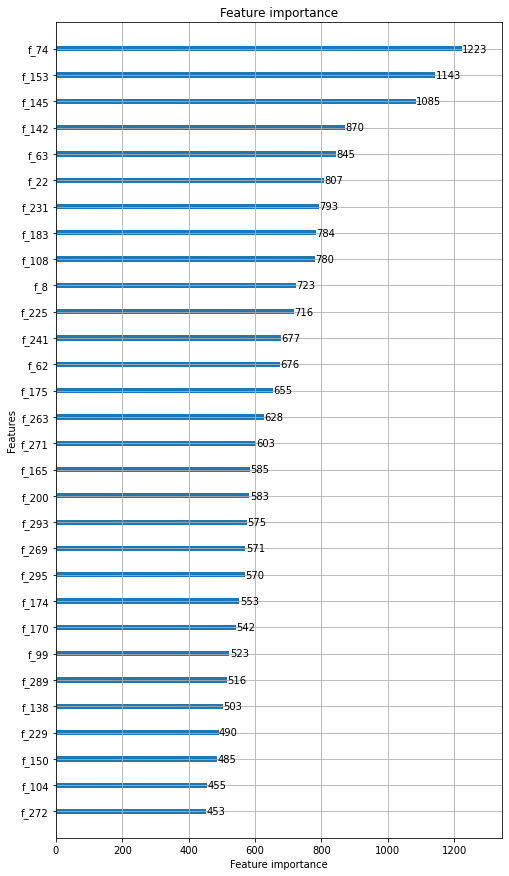

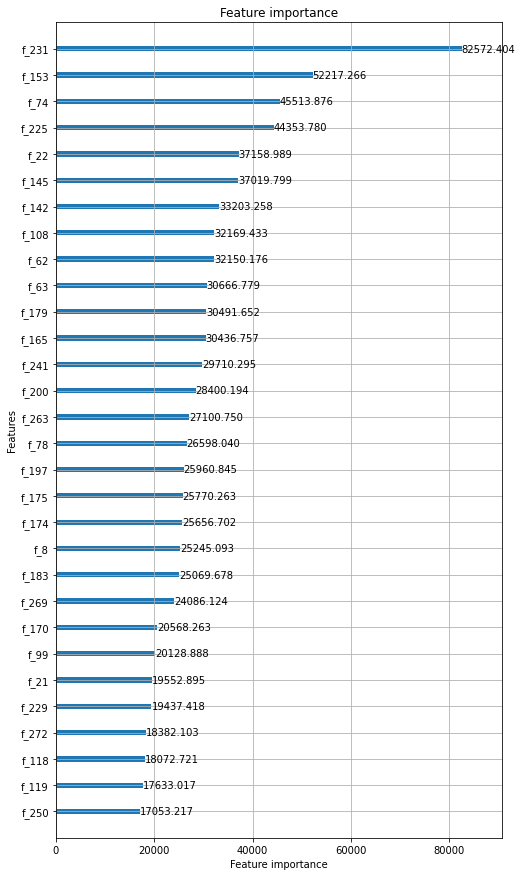

[1920]	training's rmse: 0.366438	training's pearsonr: 0.00218006
[1940]	training's rmse: 0.313294	training's pearsonr: 0.00370372
[1960]	training's rmse: 0.301788	training's pearsonr: 0.00592666
[1980]	training's rmse: 0.298685	training's pearsonr: 0.00810787
[2000]	training's rmse: 0.296147	training's pearsonr: 0.0107705
[2020]	training's rmse: 0.294769	training's pearsonr: 0.0125767
[2040]	training's rmse: 0.292711	training's pearsonr: 0.0153301
[2060]	training's rmse: 0.292464	training's pearsonr: 0.0175288
[2080]	training's rmse: 0.291991	training's pearsonr: 0.0201816
[2100]	training's rmse: 0.291805	training's pearsonr: 0.021961
[2120]	training's rmse: 0.292016	training's pearsonr: 0.0239411
[2140]	training's rmse: 0.290696	training's pearsonr: 0.0272545
[2160]	training's rmse: 0.290581	training's pearsonr: 0.0301821
[2180]	training's rmse: 0.290061	training's pearsonr: 0.0336302
[2200]	training's rmse: 0.290124	training's pearsonr: 0.0356174
[2220]	training's rmse: 0.289527	trai

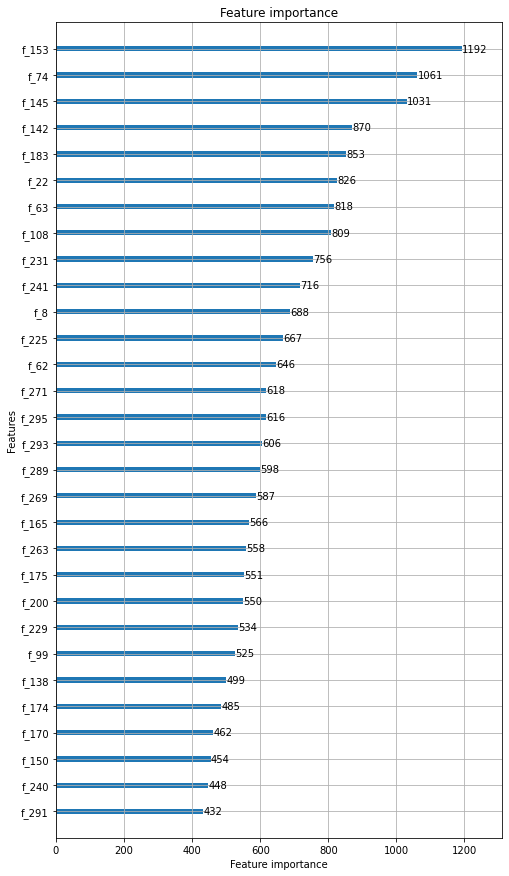

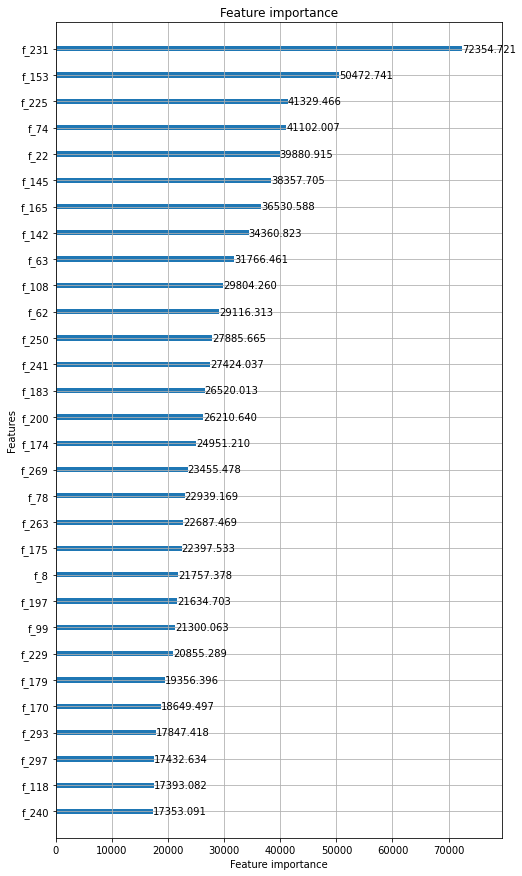

[1920]	training's rmse: 0.400052	training's pearsonr: 0.00214428
[1940]	training's rmse: 0.335088	training's pearsonr: 0.00275521
[1960]	training's rmse: 0.307141	training's pearsonr: 0.00493251
[1980]	training's rmse: 0.311787	training's pearsonr: 0.00627541
[2000]	training's rmse: 0.301791	training's pearsonr: 0.00849196
[2020]	training's rmse: 0.298105	training's pearsonr: 0.0104523
[2040]	training's rmse: 0.296228	training's pearsonr: 0.0124036
[2060]	training's rmse: 0.294208	training's pearsonr: 0.0148081
[2080]	training's rmse: 0.294301	training's pearsonr: 0.0167389
[2100]	training's rmse: 0.293246	training's pearsonr: 0.0188685
[2120]	training's rmse: 0.294304	training's pearsonr: 0.0199537
[2140]	training's rmse: 0.293678	training's pearsonr: 0.0219432
[2160]	training's rmse: 0.292042	training's pearsonr: 0.0247915
[2180]	training's rmse: 0.292097	training's pearsonr: 0.026321
[2200]	training's rmse: 0.290379	training's pearsonr: 0.030268
[2220]	training's rmse: 0.289745	trai

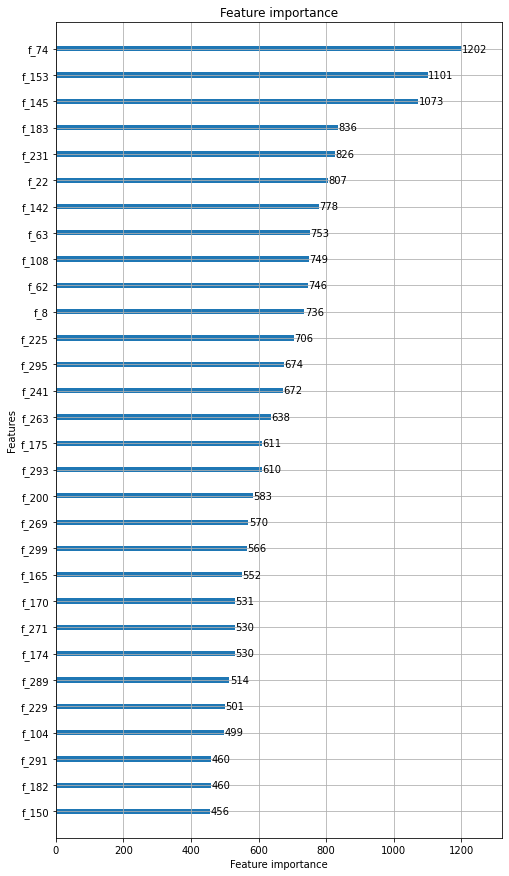

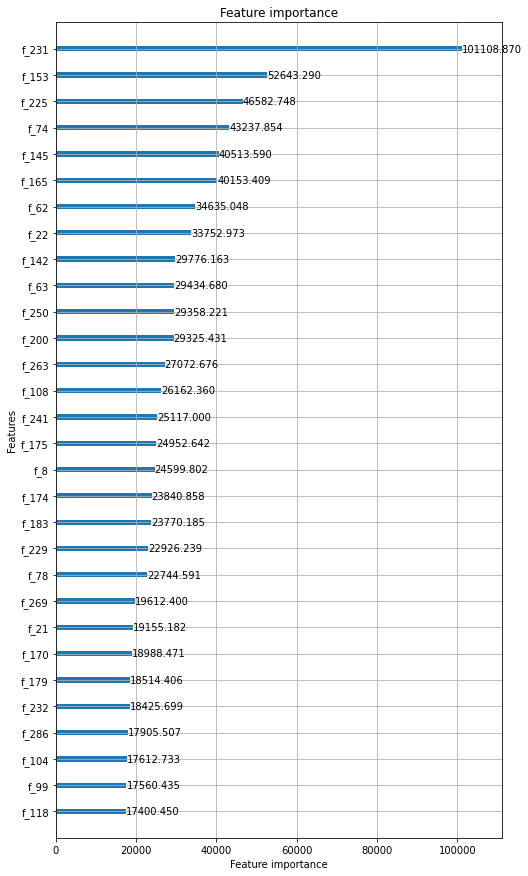

[1920]	training's rmse: 0.363691	training's pearsonr: 0.00190207
[1940]	training's rmse: 0.312358	training's pearsonr: 0.0037894
[1960]	training's rmse: 0.299232	training's pearsonr: 0.00661684
[1980]	training's rmse: 0.294961	training's pearsonr: 0.0095775
[2000]	training's rmse: 0.297638	training's pearsonr: 0.0115228
[2020]	training's rmse: 0.296172	training's pearsonr: 0.0136032
[2040]	training's rmse: 0.295635	training's pearsonr: 0.0152852
[2060]	training's rmse: 0.294777	training's pearsonr: 0.0172232
[2080]	training's rmse: 0.292772	training's pearsonr: 0.0202797
[2100]	training's rmse: 0.293124	training's pearsonr: 0.0221034
[2120]	training's rmse: 0.290919	training's pearsonr: 0.0263066
[2140]	training's rmse: 0.290611	training's pearsonr: 0.0297545
[2160]	training's rmse: 0.291027	training's pearsonr: 0.0318094
[2180]	training's rmse: 0.290398	training's pearsonr: 0.034771
[2200]	training's rmse: 0.291052	training's pearsonr: 0.036283
[2220]	training's rmse: 0.29092	training

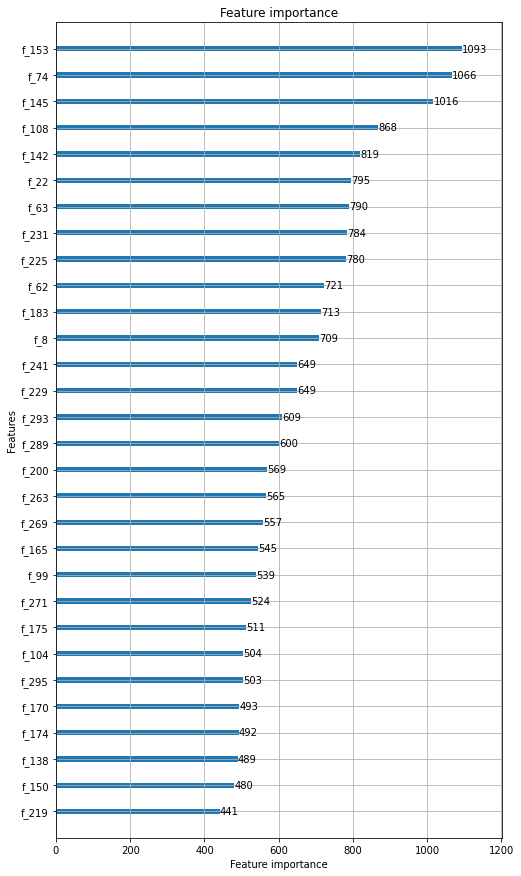

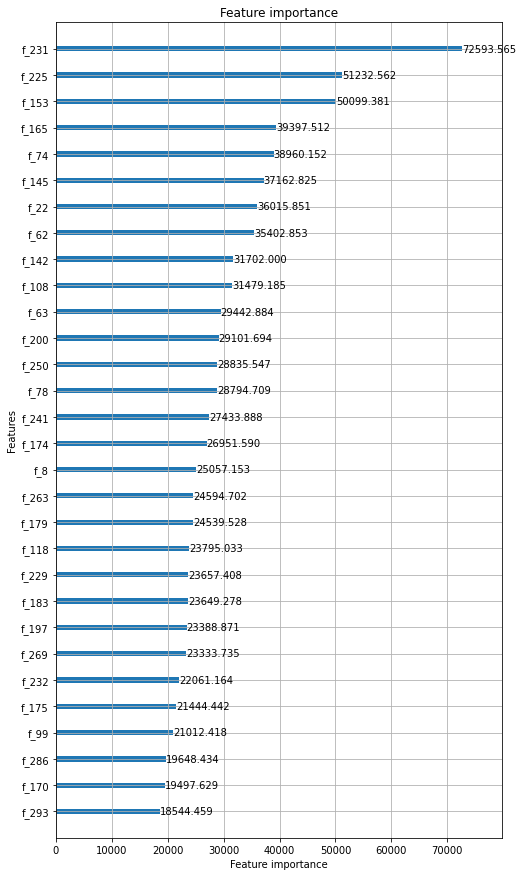

[1920]	training's rmse: 0.43243	training's pearsonr: 0.00151575
[1940]	training's rmse: 0.331513	training's pearsonr: 0.00218651
[1960]	training's rmse: 0.302047	training's pearsonr: 0.00457404
[1980]	training's rmse: 0.298766	training's pearsonr: 0.00702059
[2000]	training's rmse: 0.296806	training's pearsonr: 0.00935284
[2020]	training's rmse: 0.296303	training's pearsonr: 0.0110295
[2040]	training's rmse: 0.294355	training's pearsonr: 0.0135791
[2060]	training's rmse: 0.291633	training's pearsonr: 0.0177714
[2080]	training's rmse: 0.290635	training's pearsonr: 0.0210585
[2100]	training's rmse: 0.290554	training's pearsonr: 0.0242704
[2120]	training's rmse: 0.290695	training's pearsonr: 0.0267684
[2140]	training's rmse: 0.291218	training's pearsonr: 0.028746
[2160]	training's rmse: 0.290711	training's pearsonr: 0.0310336
[2180]	training's rmse: 0.289714	training's pearsonr: 0.0353656
[2200]	training's rmse: 0.289838	training's pearsonr: 0.0372366
[2220]	training's rmse: 0.289822	trai

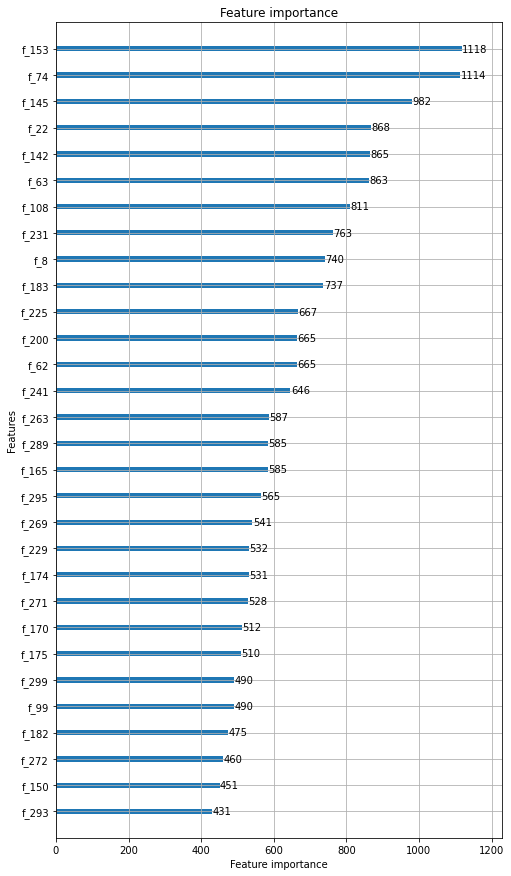

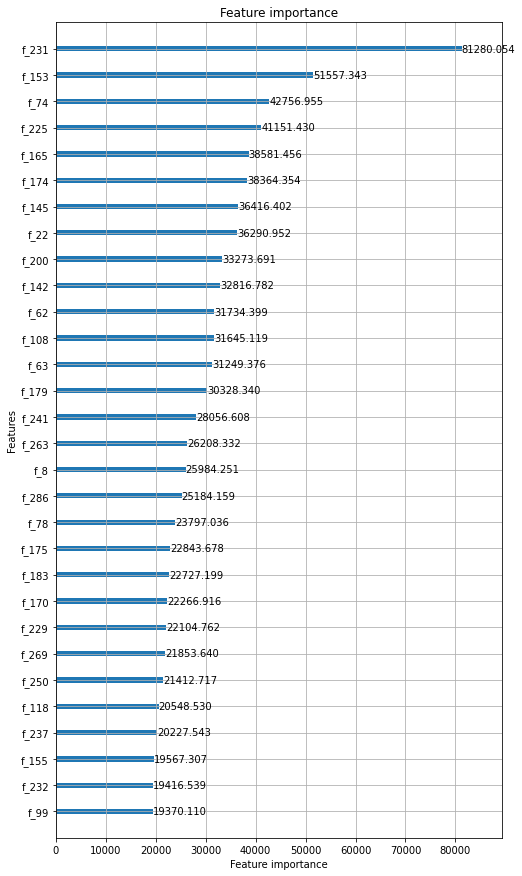

In [7]:
seeds = [2,7,11,19,23]
finetuned_models = list()

for seed,base_model in zip(seeds, boosters_lgbm_linear_dart):
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    log_callback = lgb.log_evaluation(period=20)
    
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[log_callback,],
        init_model=base_model,
    )
    finetuned_models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [8]:
del train_dset, boosters_lgbm_linear_dart
gc.collect()

17086

***
## inference

In [9]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

In [10]:
def predict(boosters, dataframe ):
    features = [f"f_{i}" for i in range(300)]
    preds = [
        model.predict(
            dataframe[features],
            start_iteration=0,
            num_iteration=model.current_iteration(),
        ) 
        for model in boosters
    ]
    return np.mean(preds, axis=0)

In [11]:
for (test_df, sample_prediction_df) in iter_test:  
    predictions = predict(finetuned_models, test_df)
    sample_prediction_df['target'] = predictions
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,row_id,target
0,1220_1,0.466385
1,1220_2,0.508332


,row_id,target
0,1221_0,0.469111
1,1221_1,0.450845
2,1221_2,0.484042


,row_id,target
0,1222_0,0.501367
1,1222_1,0.496450
2,1222_2,0.472099


,row_id,target
0,1223_0,0.505029


***